In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as sp
import pandas as pd

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.sample_bn import generate_samples
from py_banshee.prediction import inference
from py_banshee.copula_test import cvm_statistic

d:\Users\Heijden\Miniconda3\envs\scenario_generation\Lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# Generate data with a given auto correlation
n = 1000
n_hours = 48

# Generate samples
samples = np.random.normal(size=(n))
timeseries = np.cumsum(samples)

# Make a dataframe with leads on the columns
timeseries_df = pd.DataFrame(
    index=pd.date_range(start='1/1/2018', periods=n, freq='H'),
    columns=range(n_hours)
)
timeseries_df[0] = timeseries
for i in range(1, n_hours):
    timeseries_df[i] = timeseries_df[i-1].shift(-1)

In [3]:
# Name the nodes
names  = ['hour_']*n_hours
names = [names[i]+str(i+1) for i in range(n_hours)]

days=int(n_hours/24)

if days==1:
    # Define structure by giving each node a parent cell, except node 0.
    parent_cell = [[] if i==0 else [0, i-1] for i in range(n_hours)]
    parent_cell[1] = [0]
    
if days>1:
    # Define structure by giving each node a parent cell, except node 0.
    # Initialize empty structure
    parent_cell = [[] if i==0 else [int(np.floor(i/24))*24, i-1] for i in range(n_hours)]
    
    # Define the first node (connected to node 0).
    parent_cell[1] = [0]

    # Connect the nodes to the previous day.
    for i in range(24, n_hours, 24):
        parent_cell[i] = [i-1]
    
    # Connect the nodes to the previous hour.
    for i in range(24, n_hours):
        parent_cell[i] =  [i-24] + parent_cell[i]
    
    # Connect the nodes to the previous day and hour.
    parent_cell[25] = [1, 24]

In [4]:
# Calculate the rank correlation matrix
rank_corr = bn_rankcorr(
    data=timeseries_df, 
    parent_cell=parent_cell, 
    var_names=names,
    is_data=True,
    plot=False
    )

In [5]:
# Lists for the npbn
marginal_distributions = ['norm']*48
parameters = [[0,1]]*48

In [6]:
generated_samples = generate_samples(
    R=rank_corr,
    n=1000,
    names=names,
    data=[],
    empirical_data=False,
    distributions=marginal_distributions,
    parameters=parameters,
    )

Text(0.5, 1.0, 'Generated data')

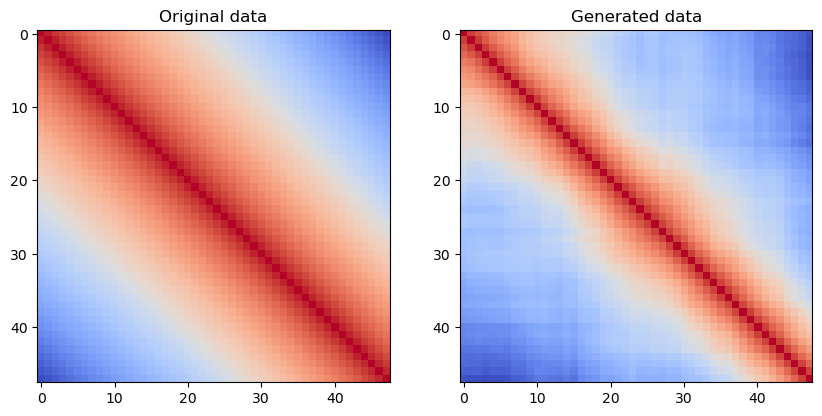

In [11]:
# Plot the correlation matrices
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(timeseries_df.corr(), cmap='coolwarm')
ax[0].set_title('Original data')
ax[1].imshow(generated_samples.corr(), cmap='coolwarm')
ax[1].set_title('Generated data')